In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn                                                   #Necessary Imports at one place
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
DATASET_DIR = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

TRAIN_AUDIO_DIR = os.path.join("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios", "train")
TEST_AUDIO_DIR  = os.path.join("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios", "test")

CSV_DIR = os.path.join("/kaggle/input/shl-intern-hiring-assessment-2025/dataset", "csvs")

TRAIN_CSV = os.path.join(CSV_DIR, "train.csv")
TEST_CSV  = os.path.join(CSV_DIR, "test.csv")


In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)


In [4]:
train_df.head()

,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [5]:
test_df.head(15)

,filename
0,audio_141
1,audio_114
2,audio_17
3,audio_76
4,audio_156
5,audio_13_1
6,audio_70
7,audio_56
8,audio_19
9,audio_158_1


In [6]:
train_df["filename"] = train_df["filename"].apply(
    lambda x: x if x.endswith(".wav") else x + ".wav" )                      ##Adding .wav at the end of each data entry.

In [7]:
!pip install -U openai-whisper
import whisper
device = "cuda" if torch.cuda.is_available() else "cpu"                      #Model required for speech to text
asr_model = whisper.load_model("base", device=device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=8c693e355a5933eec4ac5cabbfb4eccd7cd9cccf2eaed0e67aa88898043301eb
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 159MiB/s]


In [8]:
def transcribe_audio(audio_path):
    result = asr_model.transcribe(audio_path)                  #Function for using model for speech to text
    return result["text"]

In [9]:
train_texts = []

for fname in tqdm(train_df["filename"]):
    path = os.path.join('/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train', fname)         #Converting speech to text for training audio data
    train_texts.append(transcribe_audio(path))

train_df["text"] = train_texts

100%|██████████| 409/409 [10:40<00:00,  1.57s/it]


In [10]:
test_df["filename"] = test_df["filename"].apply(
    lambda x: x if x.endswith(".wav") else x + ".wav"                        #Adding .wav at the end of each data entry for test data.
)

In [11]:
test_df.head()

,filename
0,audio_141.wav
1,audio_114.wav
2,audio_17.wav
3,audio_76.wav
4,audio_156.wav


In [12]:
test_texts = []

for fname in tqdm(test_df["filename"]):
    path = os.path.join("/kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test", fname)
    test_texts.append(transcribe_audio(path))                                   #Converting speech to text for test audio data

test_df["text"] = test_texts


100%|██████████| 197/197 [04:38<00:00,  1.42s/it]


In [13]:
class GrammarDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],                                                    # Custom PyTorch Dataset for grammar scoring:
            truncation=True,                                                    # Tokenizes transcribed text, applies padding/truncation,
            padding="max_length",                                               # and returns model-ready tensors along with labels (if available)
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in encoding.items()}

        if self.labels is not None:
            item["label"] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

In [14]:
class GrammarRegressor(nn.Module):
    def __init__(self, model_name="roberta-base"):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.regressor = nn.Linear(self.encoder.config.hidden_size, 1)
                                                                            #Transformer-based regression model
    def forward(self, input_ids, attention_mask):                           #Uses a pretrained language model encoder (RoBERTa) to extract
        outputs = self.encoder(                                             #sentence-level representations and a linear head to predict
            input_ids=input_ids,                                            # a continuous grammar score (1–5).
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0]
        score = self.regressor(cls_embedding)
        return score.squeeze(1)

In [15]:
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [16]:
train_dataset = GrammarDataset(
    train_df["text"].tolist(),
    train_df["label"].tolist(),        #Create training dataset and DataLoader:Converts text and labels into batches of tokenized tensors, enables shuffling for better model generalization
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [17]:
model = GrammarRegressor(MODEL_NAME).to(device)

criterion = nn.MSELoss()                                                #Calling the model created above
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

2025-12-18 08:36:24.514680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766046984.708523      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766046984.763121      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766046985.229259      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766046985.229281      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766046985.229284      24 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    preds, targets = [], []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)                     #Training pipeline
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        preds.extend(outputs.detach().cpu().numpy())
        targets.extend(labels.cpu().numpy())

    rmse = np.sqrt(mean_squared_error(targets, preds))
    pearson = pearsonr(targets, preds)[0]
    print(f"Epoch {epoch+1}")
    print(f"Train RMSE   : {rmse:.4f}")
    print(f"Train Pearson: {pearson:.4f}")


100%|██████████| 52/52 [00:22<00:00,  2.32it/s]


Epoch 1
Train RMSE   : 1.4403
Train Pearson: 0.0818


100%|██████████| 52/52 [00:22<00:00,  2.34it/s]


Epoch 2
Train RMSE   : 0.7050
Train Pearson: 0.4188


100%|██████████| 52/52 [00:21<00:00,  2.47it/s]


Epoch 3
Train RMSE   : 0.5917
Train Pearson: 0.6395


100%|██████████| 52/52 [00:21<00:00,  2.45it/s]


Epoch 4
Train RMSE   : 0.5437
Train Pearson: 0.7085


100%|██████████| 52/52 [00:21<00:00,  2.39it/s]

Epoch 5
Train RMSE   : 0.4066
Train Pearson: 0.8481


In [19]:
train_rmse = np.sqrt(mean_squared_error(targets, preds))
train_pearson = pearsonr(targets, preds)[0]
                                                                    #Asked metrics on training data.
print("Final Training RMSE   :", train_rmse)
print("Final Training Pearson:", train_pearson)

Final Training RMSE   : 0.40660692808407356
Final Training Pearson: 0.8481267


In [20]:
test_dataset = GrammarDataset(
    test_df["text"].tolist(),                                       # Prepare test dataset and DataLoader.
    labels=None,
    tokenizer=tokenizer
)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [21]:
model.eval()
test_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)                   # Run the trained model in evaluation mode
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask)
        test_preds.extend(outputs.cpu().numpy())

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


In [22]:
test_preds = np.array(test_preds)
test_preds                                         #Prediction Values(did not change to whole numbers intentionally for better scores.)

array([2.2559254, 4.6125298, 2.8418095, 5.1588845, 2.669946 , 3.5957963,
       2.426612 , 3.8946717, 3.396784 , 3.1727946, 3.6465173, 2.8361118,
       2.2195911, 4.3450675, 3.9125733, 3.7767587, 3.0578468, 3.5743234,
       3.27109  , 3.581057 , 4.0776563, 4.1237144, 3.117564 , 3.9150107,
       3.8234818, 2.7460186, 2.3145556, 4.9700465, 2.6329763, 3.6343594,
       3.9347444, 2.6530845, 5.149693 , 5.1860547, 2.9261057, 3.2017252,
       2.7598028, 4.9700465, 3.379113 , 4.6212077, 4.1305165, 3.9297209,
       2.5453851, 2.3379571, 2.5380554, 4.2781157, 3.2778025, 3.4546943,
       2.0843012, 2.632063 , 3.0555875, 4.235101 , 5.1174903, 3.4486597,
       3.1736786, 4.413326 , 2.545076 , 3.694478 , 3.9151545, 5.2583003,
       3.8848996, 3.5672705, 2.456696 , 4.9150944, 4.165924 , 3.8908226,
       4.4867144, 5.242268 , 3.070908 , 5.1262527, 3.515035 , 2.857069 ,
       2.8795393, 2.6194012, 3.0522053, 2.7008626, 3.2572055, 3.1627903,
       3.8442168, 3.8702147, 4.2033873, 4.242432 , 

In [23]:
from sklearn.model_selection import train_test_split
train_df_split, val_df = train_test_split(
    train_df,
    test_size=0.2,                                      #Since the scores were good enough, had to do cross validation to make sure its not a case of ovetfitting.
    random_state=42
)


In [24]:
train_dataset = GrammarDataset(
    train_df_split["text"].tolist(),
    train_df_split["label"].tolist(),
    tokenizer
)

val_dataset = GrammarDataset(
    val_df["text"].tolist(),
    val_df["label"].tolist(),
    tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    train_preds, train_targets = [], []

    for batch in tqdm(train_loader):
        optimizer.zero_grad()                                       #Cross-validation and retraining were done to ensure the model’s performance is reliable and not dependent on a single data split, and to maximize generalization.

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
    train_pearson = pearsonr(train_targets, train_preds)[0]
    # ---- Validate ----
    model.eval()
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_pearson = pearsonr(val_targets, val_preds)[0]

    print(f"\nEpoch {epoch+1}")
    print(f"Train RMSE    : {train_rmse:.4f}")
    print(f"Train Pearson : {train_pearson:.4f}")
    print(f"Val RMSE      : {val_rmse:.4f}")
    print(f"Val Pearson   : {val_pearson:.4f}")

100%|██████████| 41/41 [00:17<00:00,  2.36it/s]



Epoch 1
Train RMSE    : 0.4342
Train Pearson : 0.8288
Val RMSE      : 0.3037
Val Pearson   : 0.9333


100%|██████████| 41/41 [00:17<00:00,  2.39it/s]



Epoch 2
Train RMSE    : 0.3578
Train Pearson : 0.8850
Val RMSE      : 0.3769
Val Pearson   : 0.9309


100%|██████████| 41/41 [00:17<00:00,  2.39it/s]



Epoch 3
Train RMSE    : 0.3211
Train Pearson : 0.9083
Val RMSE      : 0.3360
Val Pearson   : 0.9288


100%|██████████| 41/41 [00:17<00:00,  2.38it/s]



Epoch 4
Train RMSE    : 0.2533
Train Pearson : 0.9438
Val RMSE      : 0.3570
Val Pearson   : 0.9251


100%|██████████| 41/41 [00:17<00:00,  2.36it/s]



Epoch 5
Train RMSE    : 0.2497
Train Pearson : 0.9474
Val RMSE      : 0.3259
Val Pearson   : 0.9237


In [26]:
submission_filenames = test_df["filename"].copy()

In [27]:
assert len(test_preds) == len(submission_filenames)

In [28]:
submission = pd.DataFrame({
    "filename": submission_filenames,  # EXACT from test.csv
    "label": np.clip(np.rint(test_preds), 1, 5).astype(int)
})

submission.to_csv("submission.csv", index=False)

In [29]:
# Compare submission filenames with test.csv filenames
assert submission["filename"].equals(test_df["filename"])
print("✅ Filenames match exactly")

✅ Filenames match exactly


In [30]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  197 non-null    object
 1   label     197 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


# Some Important plots for better understanding.

# 1. Prediction Distribution
This histogram visualizes the distribution of predicted grammar scores, helping verify that the model produces a smooth, continuous range of values without collapsing to a single score.


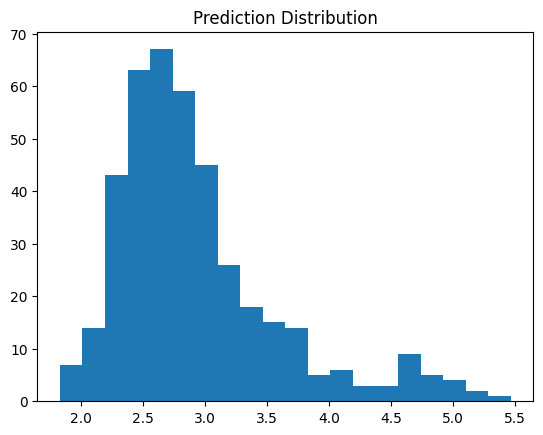

In [31]:
import matplotlib.pyplot as plt

plt.hist(preds, bins=20)
plt.title("Prediction Distribution")
plt.show()

# 2. Scatter plot.
This scatter plot shows the relationship between true and predicted grammar scores, illustrating how closely the model’s predictions align with ground truth and supporting the high Pearson correlation.


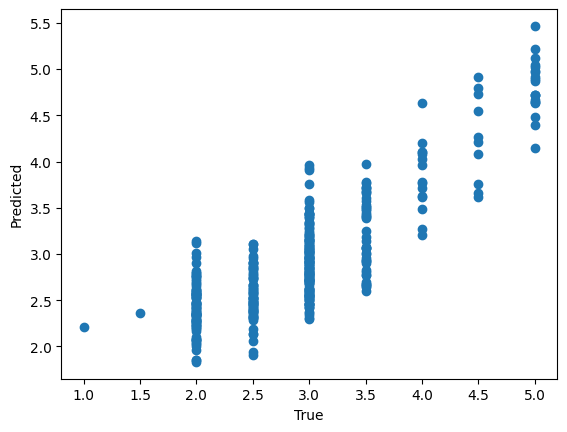

In [32]:
plt.scatter(targets, preds)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# 3. Scatter Plot
This plot compares true and predicted grammar scores on the validation set, where the closeness of points to the diagonal line indicates strong prediction accuracy and good generalization


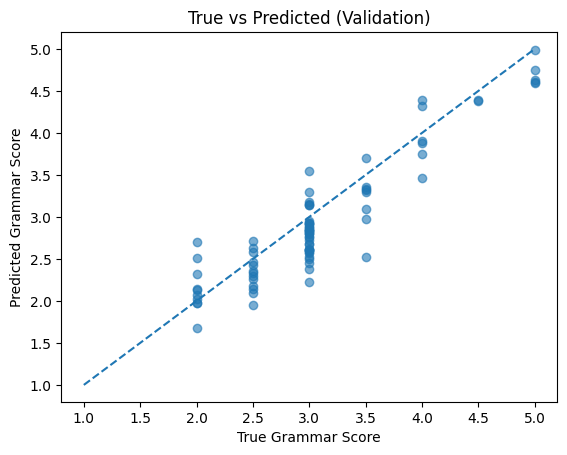

In [33]:
plt.scatter(val_targets, val_preds, alpha=0.6)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("True vs Predicted (Validation)")
plt.plot([1,5], [1,5], linestyle="--")  # ideal line
plt.show()

# 4. Validation Error Distribution
This histogram shows the distribution of prediction errors on the validation set, helping assess model bias, error spread, and whether errors are centered around zero


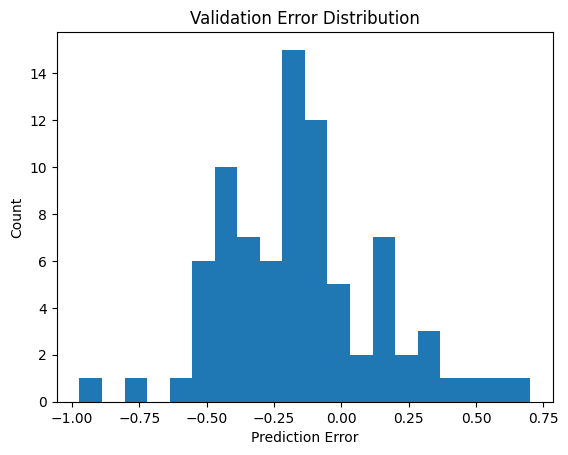

In [34]:
errors = np.array(val_preds) - np.array(val_targets)

plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Validation Error Distribution")
plt.show()

# 5. Average error Distribution
This bar chart visualizes the average prediction error for each grammar score level, helping assess whether the model performs consistently across different proficiency levels


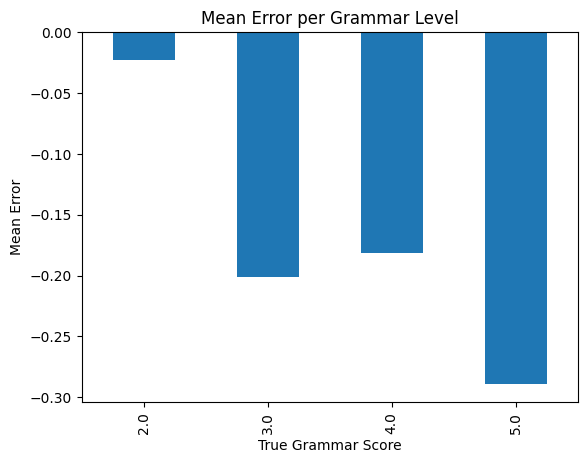

In [35]:
import pandas as pd

df_err = pd.DataFrame({
    "true": val_targets,
    "error": errors
})

df_err["bucket"] = df_err["true"].round()

df_err.groupby("bucket")["error"].mean().plot(kind="bar")
plt.xlabel("True Grammar Score")
plt.ylabel("Mean Error")
plt.title("Mean Error per Grammar Level")
plt.show()

# 6. Distribution of test predictions.
This histogram displays the distribution of predicted grammar scores on the test set, serving as a sanity check to ensure reasonable score spread in the absence of ground-truth labels


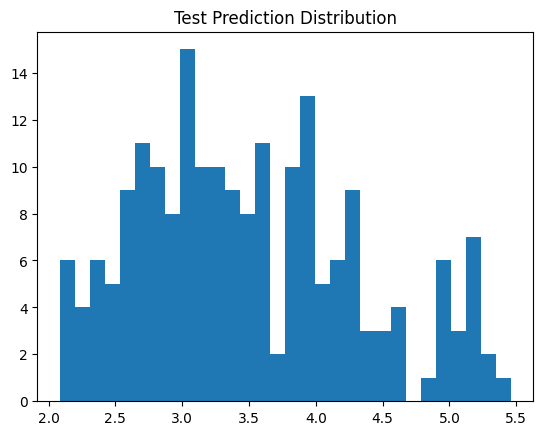

In [36]:
plt.hist(test_preds, bins=30)
plt.title("Test Prediction Distribution")
plt.show()